In [1]:
from datetime import datetime

class Ccsds:
    originator = ''
    object_name = ''
    object_id = 0
    sat_properties = {
         'mass': 0.0,
         'solar_rad_area': 0.0,
         'solar_rad_coeff': 0.0,
         'drag_area': 0.0,
         'drag_coeff': 0.0
    }

    def __init__(self, originator, object_name, object_id, sat_properties):
        """

        :param originator:
        :param object_name:
        :param object_id:
        :param sat_properties: dict containing at least:
            - mass: float, kg
            - solar_rad_area: float, area for radiation pressure in m2
            - solar_rad_coeff: float, radiation pressure coefficient
            - drag_area: float, area for drag in m2
            - drag_coeff: float, drag coefficient
        """
        self.originator = originator
        self.object_name = object_name
        self.object_id = object_id
        self.sat_properties = sat_properties

    def write_opm(self, filename, epoch, pos_array, vel_array, cov_matrix, center_name, frame_name):
        """
        Timescale is forced to UTC
        :param filename:
        :param epoch:
        :param pos_array:
        :param vel_array:
        :param cov_matrix:
        :param center_name:
        :param frame_name:
        :return:
        """

        epoch_str = f'{epoch:%Y-%m-%dT%H:%M:%S.%f}'
        pos_km = 1e-3 * pos_array
        vel_km_s = 1e-3 * vel_array

        with open(filename, 'w') as f:

            f.write('CCSDS_OPM_VERS = 2.0\n')
            f.write('\n')
            f.write(f'CREATION_DATE = {datetime.utcnow():%Y-%m-%dT%H:%M:%S}\n')
            f.write(f'ORIGINATOR = {self.originator}\n')
            f.write('\n')
            f.write(f'OBJECT_NAME = {self.object_name}\n')
            f.write(f'OBJECT_ID = {self.object_id}\n')
            f.write(f'CENTER_NAME = {center_name}\n')
            f.write(f'REF_FRAME = {frame_name}\n')
            f.write('TIME_SYSTEM = UTC\n')
            f.write('\n')
            f.write('COMMENT  Orbit determination based on SLR data\n')
            f.write('\n')

            f.write('COMMENT  State vector\n')
            f.write(f'EPOCH = {epoch_str[:-3]}\n')
            f.write(f'X = {pos_km[0]:.9f}  [km]\n')
            f.write(f'Y = {pos_km[1]:.9f}  [km]\n')
            f.write(f'Z = {pos_km[2]:.9f}  [km]\n')
            f.write(f'X_DOT = {vel_km_s[0]:.12f}  [km/s]\n')
            f.write(f'Y_DOT = {vel_km_s[1]:.12f}  [km/s]\n')
            f.write(f'Z_DOT = {vel_km_s[2]:.12f}  [km/s]\n')
            f.write('\n')

            f.write('COMMENT  Spacecraft parameters\n')
            f.write(f'MASS = {self.sat_properties["mass"]:.6f}  [kg]\n')
            f.write(f'SOLAR_RAD_AREA = {self.sat_properties["solar_rad_area"]:.6f}  [m**2]\n')
            f.write(f'SOLAR_RAD_COEFF = {self.sat_properties["solar_rad_coeff"]:.6f}\n')
            f.write(f'DRAG_AREA = {self.sat_properties["drag_area"]:.6f}  [m**2]\n')
            f.write(f'DRAG_COEFF = {self.sat_properties["drag_coeff"]:.6f}\n')
            f.write('\n')

In [2]:
def epochStringToDatetime(epochString):
    """
    Converts a string to a datetime object
    Input format: yearsInCentury:daysInYear:secondsInDay
    :param epochString: str
    :return:
    """
    from datetime import datetime, timedelta
    epochData = [int(d) for d in epochString.split(':')]
    if epochData[0] > 50: # 20th century
        epochYear = epochData[0] + 1900
    else:
        epochYear = epochData[0] + 2000
    referenceEpoch = datetime(epochYear, 1, 1) + timedelta(days=epochData[1] - 1) + timedelta(seconds=epochData[2])
    return referenceEpoch


def parseStationData(stationFile, stationEccFile, epoch):
    """
    Parses the two files containing the coordinates of laser ranging ground stations
    :param stationFile: str, path to the station coordinates file
    :param stationEccFile: str, path to the station eccentricities file
    :param epoch: datetime object. used to compute the station position based on the velocity data
    :return: a pandas DataFrame containing:
        - index: str, 8-digit id of the ground station
        - columns:
            - CODE: int, 4-digit station code (including possibly several receivers)
            - PT: str, usually A
            - Latitude: float, station latitude in degrees
            - Longitude: float, station longitude in degrees
            - Altitude: float, station altitude above WGS84 reference sea level in meters
            - OrekitGroundStation: Orekit GroundStation object
    """
    from org.orekit.utils import IERSConventions
    from org.orekit.frames import FramesFactory
    itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
    from org.orekit.models.earth import ReferenceEllipsoid
    wgs84ellipsoid = ReferenceEllipsoid.getWgs84(itrf)

    from org.hipparchus.geometry.euclidean.threed import Vector3D
    from org.orekit.frames import TopocentricFrame
    from org.orekit.estimation.measurements import GroundStation
    from numpy import rad2deg
    from orekit.pyhelpers import datetime_to_absolutedate

    import pandas as pd
    stationData = pd.DataFrame(columns=['CODE', 'PT', 'Latitude', 'Longitude', 'Altitude', 'OrekitGroundStation'])
    stationxyz = pd.DataFrame(columns=['CODE', 'PT', 'TYPE', 'SOLN', 'REF_EPOCH',
                                   'UNIT', 'S', 'ESTIMATED_VALUE', 'STD_DEV'])

    # First run on the file to initialize the ground stations using the approximate lat/lon/alt data
    with open(stationFile) as f:
        line = ''
        while not line.startswith('+SITE/ID'):
            line = f.readline()
        line = f.readline()  # Skipping +SITE/ID
        line = f.readline()  # Skipping column header

        while not line.startswith('-SITE/ID'):
            stationCode = int(line[1:5])
            pt = line[7]
            l = line[44:]
            #lon_deg = float(l[0:3]) + float(l[3:6]) / 60.0 + float(l[6:11]) / 60.0 / 60.0
            #lat_deg = float(l[12:15]) + float(l[15:18]) / 60.0 + float(l[18:23]) / 60.0 / 60.0
            #alt_m = float(l[24:31])
            station_id = l[36:44]

            #geodeticPoint = GeodeticPoint(float(deg2rad(lat_deg)), float(deg2rad(lon_deg)), alt_m)
            #topocentricFrame = TopocentricFrame(wgs84ellipsoid, geodeticPoint, str(station_id))
            #groundStation = GroundStation(topocentricFrame)

            #stationData.loc[station_id] = [stationCode, pt, lat_deg, lon_deg, alt_m, groundStation]
            stationData.loc[station_id, ['CODE', 'PT']] = [stationCode, pt] # Only filling the station code and id
            line = f.readline()        

        # Parsing accurate ground station position from XYZ
        while not line.startswith('+SOLUTION/ESTIMATE'):
            line = f.readline()        

        line = f.readline()  # Skipping +SOLUTION/ESTIMATE
        line = f.readline()  # Skipping column header

        while not line.startswith('-SOLUTION/ESTIMATE'):
            index = int(line[1:6])
            lineType = line[7:11]
            code = int(line[14:18])
            pt = line[20:21]
            soln = int(line[22:26])
            refEpochStr = line[27:39]       
            refEpoch = epochStringToDatetime(refEpochStr)
            unit = line[40:44]
            s = int(line[45:46])
            estimatedValue = float(line[47:68])
            stdDev = float(line[69:80]) 

            stationxyz.loc[index] = [code, pt, lineType, soln, refEpoch, 
                                             unit, s, estimatedValue, stdDev]
            line = f.readline() 

    pivotTable = stationxyz.pivot_table(index=['CODE', 'PT'], 
                                        columns=['TYPE'], 
                                        values=['ESTIMATED_VALUE', 'STD_DEV'])
    stationxyz.set_index(['CODE', 'PT'], inplace = True)
    
    # Reading the eccentricities data
    stationEcc = pd.DataFrame(columns=['SITE', 'PT', 'SOLN', 'T', 'DATA_START', 
                                   'DATA_END', 'XYZ', 'X', 'Y', 'Z'])

    with open(stationEccFile) as f:
        line = ''
        while not line.startswith('+SITE/ECCENTRICITY'):
            line = f.readline()
        line = f.readline() # skipping +SITE/ECCENTRICITY
        line = f.readline() # skipping table header

        while not line.startswith('-SITE/ECCENTRICITY'):
            site = int(line[0:5])
            pt = line[7:8]
            soln = int(line[9:13])
            t = line[14:15]
            dataStartStr = line[16:28]
            dataStart = epochStringToDatetime(dataStartStr)
            dataEndStr = line[29:41]
            dataEnd = epochStringToDatetime(dataEndStr)
            xyz = line[42:45]
            x = float(line[46:54])
            y = float(line[55:63])
            z = float(line[64:72])
            stationId = line[80:88]

            stationEcc.loc[stationId] = [site, pt, soln, t, dataStart,
                                          dataEnd, xyz, x, y, z]

            line = f.readline()

    stationEcc.index.name = 'CDP-SOD'

    # A loop is needed here to create the Orekit objects
    for stationId, staData in stationData.iterrows():
        indexTuple = (staData['CODE'], staData['PT'])
        refEpoch = stationxyz.loc[indexTuple, 'REF_EPOCH']
        
        # Ensure refEpoch is a single datetime value
        if isinstance(refEpoch, pd.Series):
            refEpoch = refEpoch.iloc[0]
        else:
            raise ValueError('refEpoch is not a single datetime value')

        yearsSinceEpoch = (epoch - refEpoch).days / 365.25

        pv = pivotTable.loc[indexTuple]['ESTIMATED_VALUE']
        x = float(pv['STAX'] + # Station coordinates
                  pv['VELX'] * yearsSinceEpoch + # Station displacements
                  stationEcc.loc[stationId]['X']) # Station eccentricities
        y = float(pv['STAY'] + 
                  pv['VELY'] * yearsSinceEpoch +
                  stationEcc.loc[stationId]['Y'])
        z = float(pv['STAZ'] + 
                  pv['VELZ'] * yearsSinceEpoch +
                  stationEcc.loc[stationId]['Z'])
        station_xyz_m = Vector3D(x, y, z)
        geodeticPoint = wgs84ellipsoid.transform(station_xyz_m, itrf, datetime_to_absolutedate(epoch))
        lon_deg = rad2deg(geodeticPoint.getLongitude())
        lat_deg = rad2deg(geodeticPoint.getLatitude())
        alt_m = geodeticPoint.getAltitude()
        topocentricFrame = TopocentricFrame(wgs84ellipsoid, geodeticPoint, str(indexTuple[0]))
        groundStation = GroundStation(topocentricFrame)
        stationData.loc[stationId] = [staData['CODE'], staData['PT'], lat_deg, lon_deg, alt_m, groundStation]

    return stationData

def queryCpfData(username_edc, password_edc, url, cosparId, startDate):
    """
    Queries a list of CPF predictions for a given satellite and a given date. Usually there is one or two predictions
    every day, so this function will only look for predictions published at startDate.
    :param username_edc: str, username for the EDC API
    :param password_edc: str, password for the EDC API
    :param url: str, URL for the EDC API
    :param cosparId: str, COSPAR ID of the satellite
    :param startDate: datetime object, date where CPF prediction was published
    :return: pandas DataFrame object containing:
        - index: int, CPF id
        - columns: see section "Data query" for CPF data at https://edc.dgfi.tum.de/en/api/doc/
    """
    import requests
    import json
    from datetime import datetime
    import pandas as pd

    search_args = {
        'username': username_edc,
        'password': password_edc,
        'action': 'data-query',
        'data_type': 'CPF',
        'satellite': cosparId,
        'start_data_date': '{:%Y-%m-%d}%'.format(startDate)  # Data will start at midnight
    }

    search_response = requests.post(url, data=search_args)

    dataframes = []  # List to store each DataFrame

    if search_response.status_code == 200:
        search_data = json.loads(search_response.text)

        for observation in search_data:
            startDataDate = datetime.strptime(observation['start_data_date'], '%Y-%m-%d %H:%M:%S')
            endDataDate = datetime.strptime(observation['end_data_date'], '%Y-%m-%d %H:%M:%S')

            leDataSet = pd.DataFrame.from_records([observation], index=[int(observation['id'])])
            dataframes.append(leDataSet)  # Append DataFrame to list

    else:
        print(search_response.status_code)
        print(search_response.text)

    # Concatenate all DataFrames in the list
    datasetList = pd.concat(dataframes)

    datasetList.drop('id', axis=1, inplace=True)

    return datasetList

def dlAndParseCpfData(username_edc, password_edc, url, datasetIdList, startDate, endDate):
    """
    Downloads and parses CPF prediction data. A CPF file usually contains one week of data. Using both startDate and
    endDate parameters, it is possible to truncate this data.
    :param username_edc: str, username for the EDC API
    :param password_edc: str, password for the EDC API
    :param url: str, URL for the EDC API
    :param datasetIdList: list of dataset ids to download.
    :param startDate: datetime object. Data prior to this date will be removed
    :param endDate: datetime object. Data after this date will be removed
    :return: pandas DataFrame containing:
        - index: datetime object of the data point, in UTC locale
        - columns 'x', 'y', and 'z': float, satellite position in ITRF frame in meters
    """
    import requests
    import json
    from org.orekit.time import AbsoluteDate
    from org.orekit.time import TimeScalesFactory
    from orekit.pyhelpers import absolutedate_to_datetime
    utc = TimeScalesFactory.getUTC()

    dl_args = {}
    dl_args['username'] = username_edc
    dl_args['password'] = password_edc
    dl_args['action'] = 'data-download'
    dl_args['data_type'] = 'CPF'

    import pandas as pd
    cpfDataFrame = pd.DataFrame(columns=['x', 'y', 'z'])

    for datasetId in datasetIdList:
        dl_args['id'] = str(datasetId)
        dl_response = requests.post(url, data=dl_args)

        if dl_response.status_code == 200:
            """ convert json string in python list """
            data = json.loads(dl_response.text)

            currentLine = ''
            i = 0
            n = len(data)

            while (not currentLine.startswith('10')) and i < n:  # Reading lines until the H4 header
                currentLine = data[i]
                i += 1

            while currentLine.startswith('10') and i < n:
                lineData = currentLine.split()
                mjd_day = int(lineData[2])
                secondOfDay = float(lineData[3])
                position_ecef = [float(lineData[5]), float(lineData[6]), float(lineData[7])]
                absolutedate = AbsoluteDate.createMJDDate(mjd_day, secondOfDay, utc)
                currentdatetime = absolutedate_to_datetime(absolutedate)

                if (currentdatetime >= startDate) and (currentdatetime <= endDate):
                    cpfDataFrame.loc[currentdatetime] = position_ecef

                currentLine = data[i]
                i += 1

        else:
            print(dl_response.status_code)
            print(dl_response.text)

    return cpfDataFrame

def querySlrData(username_edc, password_edc, url, dataType, cosparId, startDate, endDate):
    """
    Queries a list of SLR ground station pass data
    :param username_edc: str, username for the EDC API
    :param password_edc: str, password for the EDC API
    :param url: str, URL for the EDC API
    :param dataType: str, NPT for normal point data or FRD for full-rate data
    :param cosparId: str, COSPAR ID of the satellite
    :param startDate: datetime object, start date to look for data
    :param endDate: datetime object, end date to look for data
    :return: pandas DataFrame object, containing:
        - index: int, unique ID for the ground station pass
        - columns: see documentation for "Data query" in https://edc.dgfi.tum.de/en/api/doc/
    """
    # dataType: 'NPT' or 'FRD'
    import requests
    import json
    search_args = {}
    search_args['username'] = username_edc
    search_args['password'] = password_edc
    search_args['action'] = 'data-query'
    search_args['data_type'] = dataType
    search_args['satellite'] = cosparId

    from datetime import datetime
    from datetime import timedelta

    import pandas as pd
    datasetList = pd.DataFrame()

    numberOfDays = (endDate - startDate).days

    for i in range(int(numberOfDays) + 1):  # Making a request for each day
        endDate_current = startDate + timedelta(days=i)
        search_args['end_data_date'] = '{:%Y-%m-%d}%'.format(endDate_current)

        search_response = requests.post(url, data=search_args)

        if search_response.status_code == 200:
            search_data = json.loads(search_response.text)

            for observation in search_data:
                startDataDate = datetime.strptime(observation['start_data_date'], '%Y-%m-%d %H:%M:%S')
                endDataDate = datetime.strptime(observation['end_data_date'], '%Y-%m-%d %H:%M:%S')

                if (startDataDate >= startDate) and (
                        endDataDate <= endDate):  # Only taking the values within the date range

                    leDataSet = pd.DataFrame.from_records(observation, index=[int(observation['id'])])
                    datasetList = pd.concat([datasetList, leDataSet])
                    # print('Observation Id: {}  -  Station: {}  -  Date: {}'.format(observation['id'],
                    #                                                               observation['station'],
                    #                                                               observation['end_data_date']))

        else:
            print(search_response.status_code)
            print(search_response.text)

    if not datasetList.empty:
        datasetList.drop('id', axis=1, inplace=True)

    return datasetList

def dlAndParseSlrData(username_edc, password_edc, url, dataType, datasetList):
    """
    Download the CRD files specified by the user from the EDC API, parses it and return a Dataframe containing range and
    angles measurements

    :param username_edc: str, username for the EDC API
    :param password_edc: str, password for the EDC API
    :param url: str, URL for the EDC API
    :param dataType: str, NPT for normal point data or FRD for full-rate data
    :param datasetList: pandas Dataframe, returned by the querySlrData function
    :return: a pandas Dataframe containing:
        - index: datetime, receive time of the measurement
        - station-id: str, 8-digit id of the ground station
        - range: float, range in meters between ground station and satellite at bounce time
        - az: float, azimuth in radians of ground station at signal receive time. Often associated to range measurement,
            may not be always available
        - el: float, elevation in radians of ground station at signal receive time. Often associated to range measurement,
            may not be always available
        You should check that range, az and el are not NaN before using them
    """
    import requests
    import json
    import numpy as np
    from datetime import datetime
    from datetime import timedelta
    c = 299792458  # m/s

    dl_args = {}
    dl_args['username'] = username_edc
    dl_args['password'] = password_edc
    dl_args['action'] = 'data-download'
    dl_args['data_type'] = dataType

    import pandas as pd
    slrDataFrame = pd.DataFrame(columns=['station-id', 'range', 'az', 'el'])

    for datasetId, dataset in datasetList.iterrows():
        print('Downloading dataset {}'.format(datasetId))
        dl_args['id'] = str(datasetId)
        dl_response = requests.post(url, data=dl_args)

        if dl_response.status_code == 200:
            print('Parsing dataset {}'.format(datasetId))
            """ convert json string in python list """
            data = json.loads(dl_response.text)

            currentLine = ''
            i = 0
            n = len(data)

            while (not currentLine.lower().startswith('h4')) and i < n:  # Reading lines until the H4 header
                currentLine = data[i]
                i += 1

            lineData = currentLine.split()  # Reading day in H4 header
            y = int(lineData[2])
            m = int(lineData[3])
            d = int(lineData[4])
            measurementDay = datetime(y, m, d)

            while (not (currentLine.startswith('11') or currentLine.startswith(
                    '10'))) and i < n:  # Reading lines until the start of normal point data
                currentLine = data[i]
                i += 1

            while i < n:
                if currentLine.startswith('11') or currentLine.startswith(
                        '10'):  # Normal point or full-rate range record
                    lineData = currentLine.split()
                    timeOfDay = float(lineData[1])
                    timeOfFlight = float(lineData[2])
                    timestampType = int(lineData[4])

                    r = c * timeOfFlight / 2

                    if timestampType == 1:
                        transmitTime = measurementDay + timedelta(seconds=(timeOfDay - timeOfFlight / 2))
                    else:
                        transmitTime = measurementDay + timedelta(seconds=timeOfDay)

                    bounceTime = transmitTime + timedelta(seconds=timeOfFlight / 2)
                    receiveTime = bounceTime + timedelta(seconds=timeOfFlight / 2)

                    slrDataFrame.loc[receiveTime, ['station-id', 'range']] = [dataset['station'], r]

                elif currentLine.startswith('30'):  # Pointing angles record
                    print('Parsing angles')
                    lineData = currentLine.split()
                    timeOfDay_azel = float(lineData[1])
                    az_deg = float(lineData[2])
                    el_deg = float(lineData[3])
                    direction_flag = int(lineData[4])
                    angle_origin = int(lineData[5])
                    refraction_corrected = int(lineData[6])

                    '''
                    direction_flag is usually 0 and angle_origin 2, which means that
                    the angles were commanded and were the same for transmit and receive.
                    Therefore there is no way to correct for the satellite motion during the time of flight
                    Orekit expects the reception time
                    '''
                    if timeOfDay_azel == timeOfDay:  # Angles measurement is associated with previous range measurement
                        slrDataFrame.loc[receiveTime, ['az', 'el']] = [np.deg2rad(az_deg), np.deg2rad(el_deg)]
                    else:
                        azel_timestamp = measurementDay + timedelta(seconds=timeOfDay_azel)
                        slrDataFrame.loc[receiveTime, ['station-id', 'az', 'el']] = [dataset['station'],
                                                                                     np.deg2rad(az_deg),
                                                                                     np.deg2rad(el_deg)]

                currentLine = data[i]
                i += 1

        else:
            print(dl_response.status_code)
            print(dl_response.text)

    return slrDataFrame

def write_cpf(cpf_df, cpf_filename, ephemeris_source, production_date, ephemeris_sequence, target_name, cospar_id,
              sic, norad_id, ephemeris_start_date, ephemeris_end_date, step_time):
    """
    Writes satellite position data to a Consolidated prediction file.
    Reference: https://ilrs.cddis.eosdis.nasa.gov/docs/2006/cpf_1.01.pdf
    The function ignores leap seconds, i.e. it writes the UTC data directly and sets all leap seconds entries in the CPF file to zero

    :param cpf_df: DataFrame containing the date and position data. It must contain the following columns:
        - mjd_days: int, Modified Julian Days in UTC scale
        - seconds_of_day: float, seconds of day in UTC scale
        - x: float, satellite position in ITRF frame
        - y: float, satellite position in ITRF frame
        - z: float, satellite position in ITRF frame
    :param cpf_filename: str, filename where the data will be written
    :param ephemeris_source: str (e.g., "HON", "UTX"). Must be exactly 3 characters long
    :param production_date: datetime object. Date at which the orbit determination was performed
    :param ephemeris_sequence: int, incremented at each new orbit determination. Must be below 10000
    :param target_name: str, satellite name
    :param cospar_id: str, COSPAR ID
    :param sic: str, SIC
    :param norad_id: str, NORAD ID
    :param ephemeris_start_date: datetime
    :param ephemeris_end_date: datetime
    :param step_time: int
    """

    assert (len(ephemeris_source) == 3), 'Ephemeris source must be a string with exactly 3 characters'
    assert (ephemeris_sequence < 10000), 'Ephemeris sequence can have only 4 digits maximum'

    with open(cpf_filename, 'w') as f:
        f.write(
            f'H1 CPF  1  {ephemeris_source} {production_date:%Y %m %d %H}  {ephemeris_sequence:04} {target_name:10}           \n')
        f.write(
            f'H2 {cospar_id}  {sic}    {norad_id} {ephemeris_start_date:%Y %m %d %H %M %S} {ephemeris_end_date:%Y %m %d %H %M %S} {step_time:5} 1 1  0 0 0\n')
        f.write('H9\n')

        for key, values in cpf_df.iterrows():
            f.write(
                f"10 0 {values['mjd_days']} {values['seconds_of_day']:13.6f}  0  {values['x']:16.3f} {values['y']:16.3f} {values['z']:16.3f}\n")

        f.write('99')


def orekitPV2dataframe(PV, currentDateTime):
    import pandas as pd
    pos = PV.getPosition()
    vel = PV.getVelocity()
    data = {'DateTimeUTC': currentDateTime,
            'x': pos.getX(), 'y': pos.getY(), 'z': pos.getZ(),
            'vx': vel.getX(), 'vy': vel.getY(), 'vz': vel.getZ()}
    return pd.DataFrame(data, index=[currentDateTime])

# Orbit determination example
This notebook does the following:
* Download an orbit first guess from SpaceTrack
* Download laser ranging data
* Feed the data to Orekit
* Estimate the orbit
* Propagate and compare the orbit to the first guess

Two types of laser ranging data can be chosen (see below):

* Normal point data: https://ilrs.cddis.eosdis.nasa.gov/data_and_products/data/npt/index.html
* Full rate data: https://ilrs.cddis.eosdis.nasa.gov/data_and_products/data/frt/index.html
    * This will improve the orbit estimation
    * Caution, this format involves large quantities of data
    * Caution 2, this data is unfiltered, therefore there can be a superposition of two range curves if two retro-reflectors on the satellite are visible by the station at the same time

## OD parameters
First, some parameters need to be defined for the orbit determination:
* Satellite ID in NORAD, COSPAR and SIC code format. These IDs can be found here: https://edc.dgfi.tum.de/en/satellites/
* Spacecraft mass: important for the drag term
* Measurement weights: used to weight certain measurements more than others during the orbit estimation. Here, we only have range measurements and we do not know the confidence associated to these measurements, so all weights are identical
* OD date: date at which the orbit will be estimated. 
* Data collection duration: for example, if equals 2 days, the laser data from the 2 days before the OD date will be used to estimate the orbit. This value is an important trade-off for the quality of the orbit determination:
    * The longer the duration, the more ranging data is available, which can increase the quality of the estimation
    * The longer the duration, the longer the orbit must be propagated, and the higher the covariance because of the orbit perturbations such as the gravity field, drag, Sun, Moon, etc.

Satellite parameters

In [24]:
sat_list = {    
    'envisat': {
        'norad_id': 27386,  # For Space-Track TLE queries
        'cospar_id': '0200901',  # For laser ranging data queries
        'sic_id': '6179',  # For writing in CPF files
        'mass': 8000.0, # kg; TODO: compute proper value
        'cross_section': 100.0, # m2; TODO: compute proper value
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    },    
    'lageos2': {
        'norad_id': 22195,
        'cospar_id': '9207002',
        'sic_id': '5986',
        'mass': 405.0, # kg
        'cross_section': 0.2827, # m2
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    },
    'technosat': {
        'norad_id': 42829,
        'cospar_id': '1704205',
        'sic_id': '6203',
        'mass': 20.0, # kg
        'cross_section': 0.10, # m2,
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    },
    'snet1': {
        'norad_id': 43189,
        'cospar_id': '1801410',
        'sic_id': '6204',
        'mass': 8.0, # kg
        'cross_section': 0.07,
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    }
}

sc_name = 'technosat'  # Change the name to select a different satellite in the dict

Orbit determination parameters

In [4]:
"""
NPT: Normal point data. Recommended option. The data is pre-filtered by the laser data providers
FRD: Full-rate data. Warning, these are a lot of data points (potentially tens of thousands per day), 
    the execution time could be greatly increased 
"""
laser_data_type = 'NPT'  

range_weight = 1.0 # Will be normalized later (i.e divided by the number of observations)
range_sigma = 1.0 # Estimated covariance of the range measurements, in meters

import numpy as np
az_weight = 0.1  # Do not weigh the Az/El measurements too much because they are much less accurate than ranges
el_weight = 0.1
az_sigma = float(np.deg2rad(0.01))
el_sigma = float(np.deg2rad(0.01))

from datetime import datetime
odDate = datetime(2019, 12, 5) # Beginning of the orbit determination
collectionDuration = 2 # days
from datetime import timedelta
startCollectionDate = odDate + timedelta(days=-collectionDuration)

# Orbit propagator parameters
prop_min_step = 0.001 # s
prop_max_step = 300.0 # s
prop_position_error = 10.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-2
estimator_max_iterations = 25
estimator_max_evaluations = 35

## API credentials
The following sets up accounts for SpaceTrack (for orbit data) and the EDC API (for laser ranging data).
* A SpaceTrack account is required, it can be created for free at: https://www.space-track.org/auth/createAccount
* An EDC account is required, it can be created for free at: https://edc.dgfi.tum.de/en/register/

In [5]:
import spacetrack

# Space-Track
identity_st = input('Enter SpaceTrack username')
import getpass
password_st = getpass.getpass(prompt='Enter SpaceTrack password for account {}'.format(identity_st))
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
st = SpaceTrackClient(identity=identity_st, password=password_st)

In [6]:
# EDC API
username_edc = input('Enter EDC API username')
password_edc = getpass.getpass(prompt='Enter EDC API password for account {}'.format(username_edc)) # You will get prompted for your password
url = 'https://edc.dgfi.tum.de/api/v1/'

## Setting up models
Initializing Orekit and JVM

In [7]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir
orekit.pyhelpers.download_orekit_data_curdir()
vm = orekit.initVM()
setup_orekit_curdir()

Import station data from file

In [8]:
stationFile = 'SLRF2014_POS+VEL_2030.0_180504.snx'
stationEccFile = 'ecc_xyz.snx'
stationData = parseStationData(stationFile, stationEccFile, startCollectionDate)
display(stationData)

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_84556/4199589805.py:141: PerformanceWarning: indexing past lexsort depth may impact performance.
  refEpoch = stationxyz.loc[indexTuple, 'REF_EPOCH']


,CODE,PT,Latitude,Longitude,Altitude,OrekitGroundStation
11813901,1181,A,52.380266,13.065296,147.83227,org.orekit.estimation.measurements.GroundStati...
18248101,1824,A,50.363133,30.495888,211.560285,org.orekit.estimation.measurements.GroundStati...
18318501,1831,A,49.917573,23.95442,359.765654,org.orekit.estimation.measurements.GroundStati...
18635101,1863,A,38.68574,66.943097,2713.980094,org.orekit.estimation.measurements.GroundStati...
18645401,1864,A,38.684896,66.943093,2713.641377,org.orekit.estimation.measurements.GroundStati...
...,...,...,...,...,...,...
88331604,8833,A,52.178185,5.810174,88.604484,org.orekit.estimation.measurements.GroundStati...
88331605,8833,A,52.178185,5.810174,88.623099,org.orekit.estimation.measurements.GroundStati...
88331606,8833,A,52.178185,5.810174,88.605268,org.orekit.estimation.measurements.GroundStati...
88331607,8833,A,52.178185,5.810174,88.60253,org.orekit.estimation.measurements.GroundStati...


The orbit determination needs a first guess. For this, we use Two-Line Elements. Retrieving the latest TLE prior to the beginning of the orbit determination. It is important to have a "fresh" TLE, because the newer the TLE, the better the orbit estimation.

In [9]:
rawTle = st.tle(norad_cat_id=sat_list[sc_name]['norad_id'], epoch='<{}'.format(odDate), orderby='epoch desc', limit=1, format='tle')
tleLine1 = rawTle.split('\n')[0]
tleLine2 = rawTle.split('\n')[1]
print(tleLine1)
print(tleLine2)

1 42829U 17042E   19338.93232017 +.00000015 +00000-0 +68468-5 0  9993
2 42829 097.5429 224.5636 0013299 211.4408 148.6018 14.91030680130155


Setting up Orekit frames and models

In [10]:
from org.orekit.utils import Constants as orekit_constants
from org.orekit.frames import FramesFactory, ITRFVersion
from org.orekit.utils import IERSConventions
tod = FramesFactory.getTOD(IERSConventions.IERS_2010, False) # Taking tidal effects into account when interpolating EOP parameters
gcrf = FramesFactory.getGCRF()
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
# Selecting frames to use for OD
eci = gcrf
ecef = itrf

from org.orekit.models.earth import ReferenceEllipsoid
wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(ecef)
from org.orekit.bodies import CelestialBodyFactory
moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()

from org.orekit.time import AbsoluteDate, TimeScalesFactory
utc = TimeScalesFactory.getUTC()
mjd_utc_epoch = AbsoluteDate(1858, 11, 17, 0, 0, 0.0, utc)

Setting up the propagator from the initial TLEs

In [11]:
from org.orekit.propagation.analytical.tle import TLE
orekitTle = TLE(tleLine1, tleLine2)

from org.orekit.attitudes import NadirPointing
nadirPointing = NadirPointing(eci, wgs84Ellipsoid)

from org.orekit.propagation.analytical.tle import SGP4
sgp4Propagator = SGP4(orekitTle, nadirPointing, sat_list[sc_name]['mass'])

tleInitialState = sgp4Propagator.getInitialState()
tleEpoch = tleInitialState.getDate()
tleOrbit_TEME = tleInitialState.getOrbit()
tlePV_ECI = tleOrbit_TEME.getPVCoordinates(eci)

from org.orekit.orbits import CartesianOrbit
tleOrbit_ECI = CartesianOrbit(tlePV_ECI, eci, wgs84Ellipsoid.getGM())

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)

from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngleType
propagatorBuilder = NumericalPropagatorBuilder(tleOrbit_ECI,
                                               integratorBuilder, PositionAngleType.MEAN, estimator_position_scale)
propagatorBuilder.setMass(sat_list[sc_name]['mass'])
propagatorBuilder.setAttitudeProvider(nadirPointing)

Adding perturbation forces to the propagator

In [22]:
# Earth gravity field with degree 64 and order 64
from org.orekit.forces.gravity.potential import GravityFieldFactory
gravityProvider = GravityFieldFactory.getNormalizedProvider(64, 64)
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
gravityAttractionModel = HolmesFeatherstoneAttractionModel(ecef, gravityProvider)
propagatorBuilder.addForceModel(gravityAttractionModel)

# Moon and Sun perturbations
from org.orekit.forces.gravity import ThirdBodyAttraction
moon_3dbodyattraction = ThirdBodyAttraction(moon)
propagatorBuilder.addForceModel(moon_3dbodyattraction)
sun_3dbodyattraction = ThirdBodyAttraction(sun)
propagatorBuilder.addForceModel(sun_3dbodyattraction)

# Solar radiation pressure
from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient, IsotropicRadiationClassicalConvention
isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(float(sat_list[sc_name]['cross_section']), float(sat_list[sc_name]['cr']))
cross_section = float(sat_list[sc_name]['cross_section'])
cr = float(sat_list[sc_name]['cr'])

from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient
isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(cross_section, cr)
from org.orekit.forces.radiation import SolarRadiationPressure
solarRadiationPressure = SolarRadiationPressure(sun, wgs84Ellipsoid,
                                                isotropicRadiationSingleCoeff)
propagatorBuilder.addForceModel(solarRadiationPressure)

# Relativity
from org.orekit.forces.gravity import Relativity
relativity = Relativity(orekit_constants.EIGEN5C_EARTH_MU)
propagatorBuilder.addForceModel(relativity)

Adding atmospheric drag to the propagator

In [23]:
# Atmospheric drag
from org.orekit.models.earth.atmosphere.data import MarshallSolarActivityFutureEstimation
msafe = MarshallSolarActivityFutureEstimation(
    MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES,
    MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE)

from org.orekit.models.earth.atmosphere import NRLMSISE00
atmosphere = NRLMSISE00(msafe, sun, wgs84Ellipsoid)
#from org.orekit.forces.drag.atmosphere import DTM2000
#atmosphere = DTM2000(msafe, sun, wgs84Ellipsoid)
from org.orekit.forces.drag import IsotropicDrag
isotropicDrag = IsotropicDrag(sat_list[sc_name]['cross_section'], sat_list[sc_name]['cd'])
from org.orekit.forces.drag import DragForce
dragForce = DragForce(atmosphere, isotropicDrag)
propagatorBuilder.addForceModel(dragForce)

Setting up the estimator

In [14]:
from org.hipparchus.linear import QRDecomposer
matrixDecomposer = QRDecomposer(1e-11)
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
optimizer = GaussNewtonOptimizer(matrixDecomposer, False)
from org.orekit.estimation.leastsquares import BatchLSEstimator
estimator = BatchLSEstimator(optimizer, propagatorBuilder)
estimator.setParametersConvergenceThreshold(estimator_convergence_thres)
estimator.setMaxIterations(estimator_max_iterations)
estimator.setMaxEvaluations(estimator_max_evaluations)

## Fetching range data
Looking for laser ranging data prior to the OD date.

The API only allows to look for data using the date formats 2018-07-1%, 2018-07-14% or 2018-07-14 0% for example. As a consequence, the search must be split into several days. The results are then sorted, and the observations which are outside of the date range are deleted.

In [15]:
laserDatasetList = querySlrData(username_edc, password_edc, url, laser_data_type,
                                         sat_list[sc_name]['cospar_id'], startCollectionDate, odDate)
display(laserDatasetList)

,end_data_date,errors,incoming_date,incoming_filename,observations,satellite,start_data_date,station,status,version,wavelength
2091566,2019-12-03 01:29:56,,2019-12-03 06:41:26,7237_technosat_crd_20191203_01_00.npt,7,1704205,2019-12-03 01:28:02,72371901,valid,00,532.000
2091540,2019-12-03 02:49:36,W11101,2019-12-03 06:27:11,nasa_201912030600.npt,19,1704205,2019-12-03 02:44:36,70900513,warning,00,532.000
2091807,2019-12-03 09:35:26,,2019-12-03 15:11:15,7840_technosat_crd_20191203_09_00.npt,11,1704205,2019-12-03 09:32:49,78403501,valid,00,532.080
2092187,2019-12-03 11:57:07,,2019-12-04 01:44:00,7825_technosat_20191203_11_00.NPT,8,1704205,2019-12-03 11:51:12,78259001,valid,00,532.100
2091943,2019-12-03 13:14:51,,2019-12-03 18:27:09,nasa_201912031800.npt,9,1704205,2019-12-03 13:11:18,78383603,valid,00,532.000
2091801,2019-12-03 13:13:45,,2019-12-03 15:09:44,7237_technosat_crd_20191203_13_00.npt,9,1704205,2019-12-03 13:11:24,72371901,valid,00,532.000
2091824,2019-12-03 13:32:10,W11101,2019-12-03 15:27:10,nasa_201912031500.npt,9,1704205,2019-12-03 13:30:02,70900513,warning,00,532.000
2091901,2019-12-03 14:20:43,W50051,2019-12-03 17:27:10,nasa_201912031700.npt,2,1704205,2019-12-03 14:20:20,71050725,warning,00,532.000
2091802,2019-12-03 14:50:07,,2019-12-03 15:09:43,7237_technosat_crd_20191203_14_00.npt,12,1704205,2019-12-03 14:46:08,72371901,valid,00,532.000
2092219,2019-12-04 01:37:18,,2019-12-04 03:05:05,7237_technosat_crd_20191204_01_00.npt,4,1704205,2019-12-04 01:36:35,72371901,valid,00,532.000


Downloading the list of observations.

In [16]:
slrDataFrame = dlAndParseSlrData(username_edc, password_edc, url, laser_data_type, laserDatasetList)
display(slrDataFrame)

Parsing dataset 2091566
Parsing dataset 2091540
Parsing dataset 2091807
Parsing dataset 2092187
Parsing dataset 2091943
Parsing dataset 2091801
Parsing dataset 2091824
Parsing dataset 2091901
Parsing dataset 2091802
Parsing dataset 2092219
Parsing dataset 2092282
Parsing dataset 2352510
Parsing dataset 2092497
Parsing dataset 2092537
Parsing dataset 2092972
Parsing dataset 2092632
Parsing dataset 2092573
Parsing dataset 2092623
Parsing dataset 2092624
Parsing dataset 2092732
Parsing dataset 2093255
Parsing dataset 2093217
Parsing dataset 2093085


,station-id,range,az,el
2019-12-03 01:28:10.306585,72371901,687159.320202,NaN,NaN
2019-12-03 01:28:21.125541,72371901,680541.587263,NaN,NaN
2019-12-03 01:28:36.518583,72371901,686715.465176,NaN,NaN
2019-12-03 01:29:12.220275,72371901,766478.387604,NaN,NaN
2019-12-03 01:29:22.110353,72371901,802114.570488,NaN,NaN
...,...,...,...,...
2019-12-04 21:22:14.934114,78272201,915466.945921,NaN,NaN
2019-12-04 21:22:23.603340,78272201,949373.408765,NaN,NaN
2019-12-04 22:58:43.114993,78403501,1039980.621397,NaN,NaN
2019-12-04 22:58:52.970411,78403501,1095960.109804,NaN,NaN


Adding the measurements to the estimator

In [17]:
from orekit.pyhelpers import datetime_to_absolutedate, JArray
from org.orekit.estimation.measurements import Range, AngularAzEl, ObservableSatellite, PV

observableSatellite = ObservableSatellite(0) # Propagator index = 0

for receiveTime, slrData in slrDataFrame.iterrows():
    if slrData['station-id'] in stationData.index: # Checking if station exists in the SLRF2014_POS+VEL, because it might not be up-to-date
        if not np.isnan(slrData['range']):  # If this data point contains a valid range measurement
            orekitRange = Range(stationData.loc[slrData['station-id'], 'OrekitGroundStation'], 
                                True, # Two-way measurement
                                datetime_to_absolutedate(receiveTime),
                                slrData['range'],
                                range_sigma,
                                range_weight,
                                observableSatellite
                               ) # Uses date of signal reception; https://www.orekit.org/static/apidocs/org/orekit/estimation/measurements/Range.html
            estimator.addMeasurement(orekitRange)
        if not np.isnan(slrData['az']):  # If this data point contains a valid angles measurement
            orekitAzEl = AngularAzEl(stationData.loc[slrData['station-id'], 'OrekitGroundStation'],
                                    datetime_to_absolutedate(receiveTime),
                                    JArray('double')([slrData['az'], slrData['el']]),
                                    JArray('double')([az_sigma, el_sigma]),
                                    JArray('double')([az_weight, el_weight]),
                                    observableSatellite)
            estimator.addMeasurement(orekitAzEl)

## Performing the OD
Estimate the orbit. This step can take a long time.

In [18]:
estimatedPropagatorArray = estimator.estimate()

## Propagating the estimated orbit

In [19]:
dt = 300.0
date_start = datetime_to_absolutedate(startCollectionDate)
date_start = date_start.shiftedBy(-86400.0)
date_end = datetime_to_absolutedate(odDate)
date_end = date_end.shiftedBy(86400.0) # Stopping 1 day after OD date

# First propagating in ephemeris mode
estimatedPropagator = estimatedPropagatorArray[0]
estimatedInitialState = estimatedPropagator.getInitialState()
actualOdDate = estimatedInitialState.getDate()
estimatedPropagator.resetInitialState(estimatedInitialState)
estimatedgenerator = estimatedPropagator.getEphemerisGenerator()  

# Propagating from 1 day before data collection
# To 1 week after orbit determination (for CPF generation)
estimatedPropagator.propagate(date_start, datetime_to_absolutedate(odDate).shiftedBy(7 * 86400.0))
bounded_propagator = estimatedgenerator.getGeneratedEphemeris()

## Covariance analysis
Creating the LVLH frame, computing the covariance matrix in both TOD and LVLH frames

In [20]:
# Creating the LVLH frame 
# It must be associated to the bounded propagator, not the original numerical propagator
from org.orekit.frames import LocalOrbitalFrame
from org.orekit.frames import LOFType
lvlh = LocalOrbitalFrame(eci, LOFType.LVLH, bounded_propagator, 'LVLH')

# Getting covariance matrix in ECI frame
covMat_eci_java = estimator.getPhysicalCovariances(1.0e-10)

# Converting matrix to LVLH frame
# Getting an inertial frame aligned with the LVLH frame at this instant
# The LVLH is normally not inertial, but this should not affect results too much
# Reference: David Vallado, Covariance Transformations for Satellite Flight Dynamics Operations, 2003
eci2lvlh_frozen = eci.getTransformTo(lvlh, actualOdDate).freeze() 

# Computing Jacobian
from org.orekit.utils import CartesianDerivativesFilter
from orekit.pyhelpers import JArray_double2D
jacobianDoubleArray = JArray_double2D(6, 6)
eci2lvlh_frozen.getJacobian(CartesianDerivativesFilter.USE_PV, jacobianDoubleArray)
from org.hipparchus.linear import Array2DRowRealMatrix
jacobian = Array2DRowRealMatrix(jacobianDoubleArray)
# Applying Jacobian to convert matrix to lvlh
covMat_lvlh_java = jacobian.multiply(
    covMat_eci_java.multiply(jacobian.transpose()))

# Converting the Java matrices to numpy
import numpy as np
covarianceMat_eci = np.matrix([covMat_eci_java.getRow(iRow)
                              for iRow in range(0, covMat_eci_java.getRowDimension())])
covarianceMat_lvlh = np.matrix([covMat_lvlh_java.getRow(iRow)
                              for iRow in range(0, covMat_lvlh_java.getRowDimension())])

Computing the position and velocity standard deviation 

Position std: cross-track 9.032e-02 m, along-track 3.718e-01 m, out-of-plane 2.267e-01 m
Velocity std: cross-track 3.581e-04 m/s, along-track 9.807e-05 m/s, out-of-plane 2.741e-04 m/s


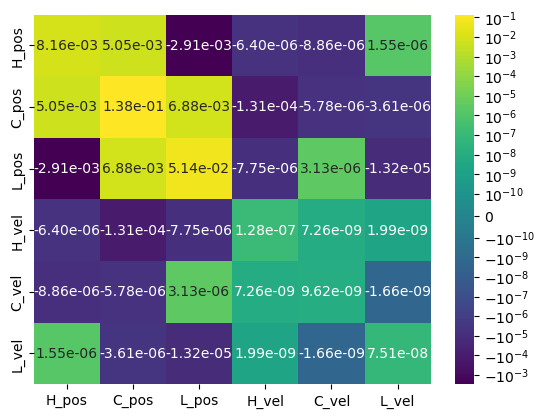

In [21]:
pos_std_crossTrack = np.sqrt(covarianceMat_lvlh[0,0])
pos_std_alongTrack = np.sqrt(covarianceMat_lvlh[1,1])
pos_std_outOfPlane = np.sqrt(covarianceMat_lvlh[2,2])
print(f'Position std: cross-track {pos_std_crossTrack:.3e} m, along-track {pos_std_alongTrack:.3e} m, out-of-plane {pos_std_outOfPlane:.3e} m')

vel_std_crossTrack = np.sqrt(covarianceMat_lvlh[3,3])
vel_std_alongTrack = np.sqrt(covarianceMat_lvlh[4,4])
vel_std_outOfPlane = np.sqrt(covarianceMat_lvlh[5,5])
print(f'Velocity std: cross-track {vel_std_crossTrack:.3e} m/s, along-track {vel_std_alongTrack:.3e} m/s, out-of-plane {vel_std_outOfPlane:.3e} m/s')

# Position std: cross-track 9.030e-02 m, along-track 3.719e-01 m, out-of-plane 2.267e-01 m
# Velocity std: cross-track 3.581e-04 m/s, along-track 9.809e-05 m/s, out-of-plane 2.741e-04 m/s

#plot a heatmap of the covariance matrix, and include the values in the plot

import seaborn as sns
import matplotlib.pyplot as plt
labels = ['H_pos', 'C_pos', 'L_pos', 'H_vel', 'C_vel', 'L_vel']
from matplotlib.colors import SymLogNorm
log_norm = SymLogNorm(linthresh=1e-10, vmin=covarianceMat_lvlh.min(), vmax=covarianceMat_lvlh.max())
sns.heatmap(covarianceMat_lvlh, annot=True, fmt=".2e", xticklabels=labels, yticklabels=labels, cmap="viridis", norm=log_norm)
plt.show()


## CCSDS OPM
Writing a CCSDS OPM message

In [28]:
sat_properties = {
     'mass': sat_list[sc_name]['mass'],
     'solar_rad_area': sat_list[sc_name]['cross_section'],
     'solar_rad_coeff': sat_list[sc_name]['cd'],
     'drag_area': sat_list[sc_name]['cross_section'],
     'drag_coeff': sat_list[sc_name]['cr']
}

ccsds_writer = Ccsds(originator='GOR', object_name=sc_name, object_id=sat_list[sc_name]['norad_id'], sat_properties=sat_properties)

pv_eci_init = estimatedInitialState.getPVCoordinates()
pos_eci_init = np.array(pv_eci_init.getPosition().toArray())
vel_eci_init = np.array(pv_eci_init.getVelocity().toArray())

from orekit.pyhelpers import absolutedate_to_datetime

ccsds_writer.write_opm('OPM.txt', absolutedate_to_datetime(actualOdDate), pos_eci_init, vel_eci_init, covarianceMat_eci, 'EARTH', 'GCRF')

## Analyzing residuals
Getting the estimated and measured ranges.

In [29]:
propagatorParameters   = estimator.getPropagatorParametersDrivers(True)
measurementsParameters = estimator.getMeasurementsParametersDrivers(True)

lastEstimations = estimator.getLastEstimations()
valueSet = lastEstimations.values()
estimatedMeasurements = valueSet.toArray()
keySet = lastEstimations.keySet()
realMeasurements = keySet.toArray()

from org.orekit.estimation.measurements import EstimatedMeasurement

import pandas as pd
range_residuals = pd.DataFrame(columns=['range'])
azel_residuals = pd.DataFrame(columns=['az', 'el'])

for estMeas, realMeas in zip(estimatedMeasurements, realMeasurements):
    estMeas = EstimatedMeasurement.cast_(estMeas)
    estimatedValue = estMeas.getEstimatedValue()
    pyDateTime = absolutedate_to_datetime(estMeas.date)
    
    if Range.instance_(realMeas):
        observedValue = Range.cast_(realMeas).getObservedValue()
        range_residuals.loc[pyDateTime] = np.array(observedValue) - np.array(estimatedValue)
    elif AngularAzEl.instance_(realMeas):
        observedValue = AngularAzEl.cast_(realMeas).getObservedValue()
        azel_residuals.loc[pyDateTime] = np.array(observedValue) - np.array(estimatedValue)
        
display(range_residuals)
display(azel_residuals)

,range
2019-12-03 13:11:27.579322,0.679898
2019-12-04 21:21:24.651292,5.315529
2019-12-03 14:50:02.797761,7.701369
2019-12-03 13:32:10.910671,4.171717
2019-12-04 13:39:22.106624,5.802908
...,...
2019-12-04 21:22:23.603339,10.782515
2019-12-03 14:46:35.694527,4.437854
2019-12-04 09:43:38.069220,2.090401
2019-12-04 02:52:53.308008,20.476945


,az,el


Plotting range residuals

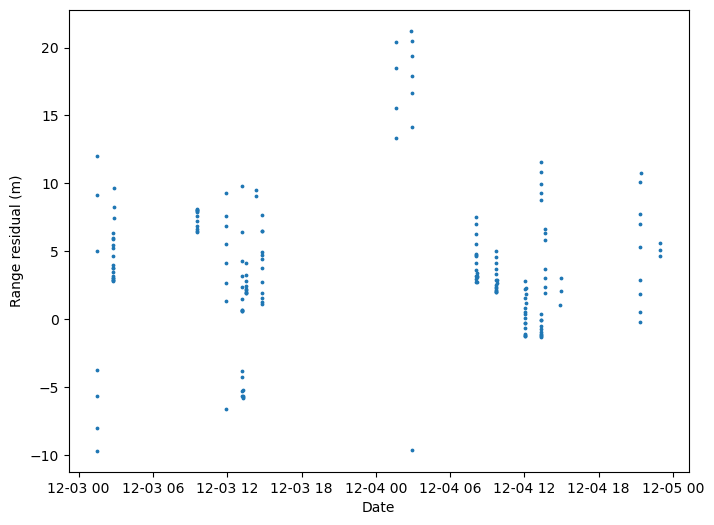

In [44]:
#plot in matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(range_residuals.index, range_residuals['range'],  s=3,marker='o')
plt.xlabel('Date')
plt.ylabel('Range residual (m)')
plt.show()


Plotting angles residuals (if available)

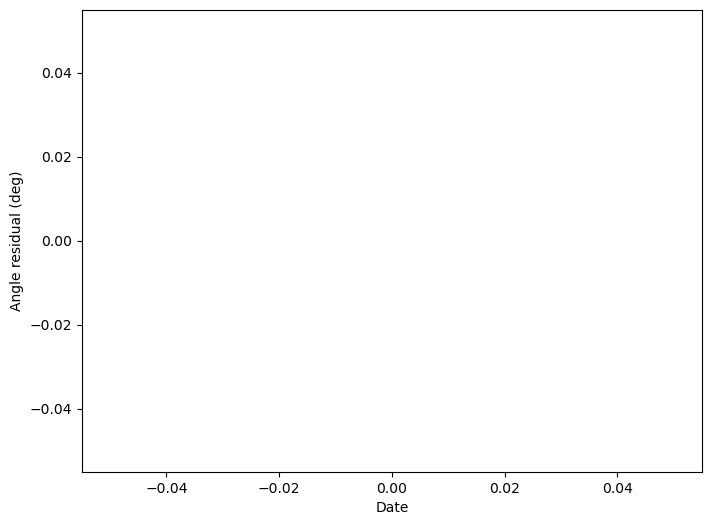

In [45]:
#same as above but in matplotlib
plt.figure(figsize=(8,6))
plt.scatter(azel_residuals.index, np.rad2deg(azel_residuals['az']),  s=3,marker='o')
plt.scatter(azel_residuals.index, np.rad2deg(azel_residuals['el']),  s=3,marker='o')
plt.xlabel('Date')
plt.ylabel('Angle residual (deg)')
plt.show()


## Comparison with CPF
The EDC API also provides Consolidated Prediction Files, which contain spacecraft position/velocity in ITRF frame as generated by their orbit determination system. We can compare our orbit determination with the one from the latest CPF prior to the first ranging data used in our orbit determination.

Requesting CPF data

In [25]:
cpfList = queryCpfData(username_edc, password_edc, url, 
                       sat_list[sc_name]['cospar_id'], startCollectionDate - timedelta(days=1))
display(cpfList)

ValueError: No objects to concatenate

Downloading and parsing CPF data

In [49]:
cpfDataFrame = dlAndParseCpfData(username_edc, password_edc, url, 
                                 [cpfList.index[0]], # If several ephemerides are available for this day, only take the first
                                 startCollectionDate - timedelta(days=1),
                                 odDate + timedelta(days=1))
display(cpfDataFrame)

,x,y,z
2019-12-02 00:00:00,2489848.967,-385646.582,6498180.758
2019-12-02 00:01:00,2845652.509,-620274.507,6331562.411
2019-12-02 00:02:00,3187447.336,-855349.183,6138153.678
2019-12-02 00:03:00,3513792.939,-1089752.660,5918762.008
2019-12-02 00:04:00,3823322.152,-1322356.625,5674305.105
...,...,...,...
2019-12-05 23:56:00,-4495849.272,1617983.184,-5090781.487
2019-12-05 23:57:00,-4754099.529,1826885.424,-4776385.865
2019-12-05 23:58:00,-4990639.898,2030302.986,-4441844.677
2019-12-05 23:59:00,-5204527.194,2227187.854,-4088564.094


## Propagating the solution 
Propagating the solution and:
* Saving the PV coordinates from both the solution and the initial TLE guess.
* Computing the difference in LVLH frame between the solution and the initial TLE guess.
* Computing the difference in LVLH frame between the solution and the CPF file.

In [58]:
# First, ensure you have these imports at the beginning of your script
import pandas as pd
from java.util import ArrayList
from org.hipparchus.geometry.euclidean.threed import Vector3D

# The function 'orekitPV2dataframe' remains the same.

# Initialize lists to store the DataFrames for concatenation
PV_eci_dfs = []
PV_ecef_dfs = []
PV_tle_eci_dfs = []
deltaPV_tle_lvlh_data = []
deltaPV_cpf_lvlh_data = []

# Saving all intermediate
states_list = ArrayList()

date_current = date_start
while date_current.compareTo(date_end) <= 0:
    datetime_current = absolutedate_to_datetime(date_current)    
    spacecraftState = bounded_propagator.propagate(date_current)
    
    states_list.add(spacecraftState)
    
    PV_eci = spacecraftState.getPVCoordinates(eci)
    PV_eci_dfs.append(orekitPV2dataframe(PV_eci, datetime_current))
    
    PV_ecef = spacecraftState.getPVCoordinates(ecef)
    PV_ecef_dfs.append(orekitPV2dataframe(PV_ecef, datetime_current))
    
    PV_tle_eci = sgp4Propagator.getPVCoordinates(date_current, eci)
    PV_tle_eci_dfs.append(orekitPV2dataframe(PV_tle_eci, datetime_current))
    
    # Handling deltaPV_tle_lvlh and deltaPV_cpf_lvlh
    deltaPV_lvlh = sgp4Propagator.getPVCoordinates(date_current, lvlh)
    deltaPV_tle_lvlh_data.append([datetime_current, deltaPV_lvlh.getPosition().getX(),
                                  deltaPV_lvlh.getPosition().getY(), 
                                  deltaPV_lvlh.getPosition().getZ(),
                                  deltaPV_lvlh.getPosition().getNorm(),
                                  deltaPV_lvlh.getVelocity().getX(),
                                  deltaPV_lvlh.getVelocity().getY(), 
                                  deltaPV_lvlh.getVelocity().getZ(),
                                  deltaPV_lvlh.getVelocity().getNorm()])
    
    pos_cpf_ecef = cpfDataFrame.loc[datetime_current]
    ecef2lvlh = ecef.getStaticTransformTo(lvlh, date_current)
    delta_pos_cpf_lvlh_vector = ecef2lvlh.transformPosition(Vector3D(float(pos_cpf_ecef[0]), float(pos_cpf_ecef[1]), float(pos_cpf_ecef[2])))
    deltaPV_cpf_lvlh_data.append([datetime_current, delta_pos_cpf_lvlh_vector.getX(),
                                  delta_pos_cpf_lvlh_vector.getY(), 
                                  delta_pos_cpf_lvlh_vector.getZ(),
                                  delta_pos_cpf_lvlh_vector.getNorm()])
    
    date_current = date_current.shiftedBy(dt)

# Concatenating all DataFrames after the loop
PV_eci_df = pd.concat(PV_eci_dfs, ignore_index=True)
PV_ecef_df = pd.concat(PV_ecef_dfs, ignore_index=True)
PV_tle_eci_df = pd.concat(PV_tle_eci_dfs, ignore_index=True)
deltaPV_tle_lvlh_df = pd.DataFrame(deltaPV_tle_lvlh_data, columns=['DateTimeUTC', 'x', 'y', 'z', 'pos_norm', 'vx', 'vy', 'vz', 'vel_norm'])
deltaPV_cpf_lvlh_df = pd.DataFrame(deltaPV_cpf_lvlh_data, columns=['DateTimeUTC', 'x', 'y', 'z', 'norm'])


/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_36012/4193992218.py:47: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



## Plotting difference between estimated orbit and CPF

Plotting position difference. The grey area represents the time window where range measurements were used to perform the orbit determination.

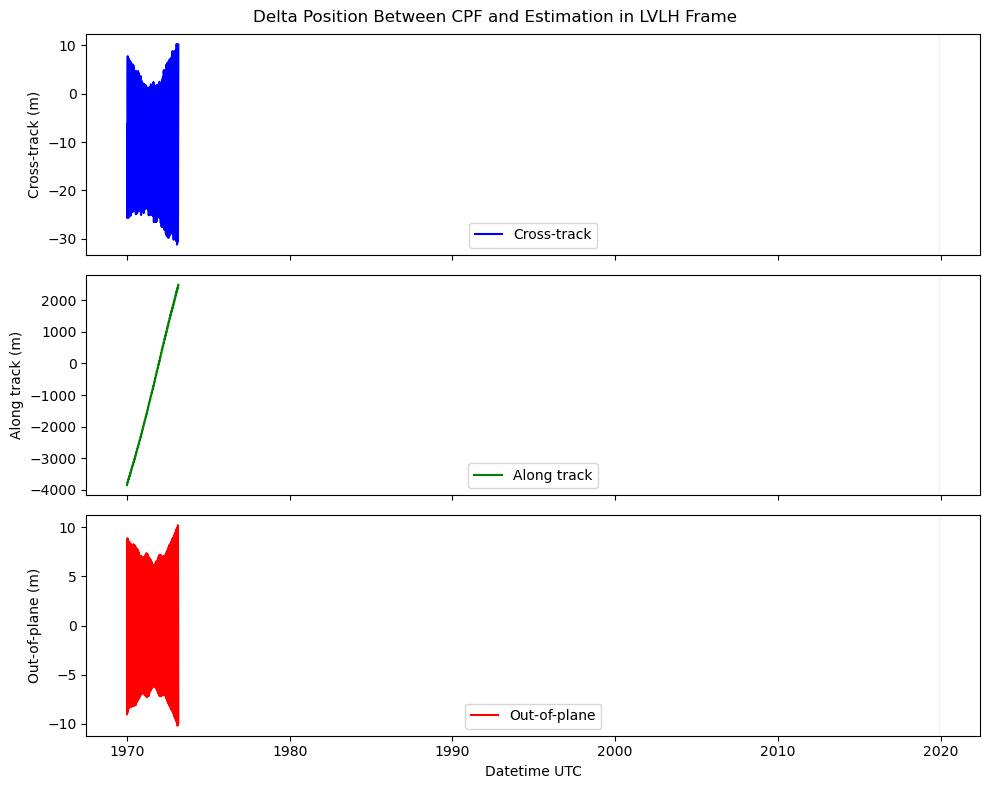

In [62]:
# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plotting each dataset in a separate subplot
axs[0].plot(deltaPV_cpf_lvlh_df.index, deltaPV_cpf_lvlh_df['x'], label='Cross-track', color='blue')
axs[1].plot(deltaPV_cpf_lvlh_df.index, deltaPV_cpf_lvlh_df['y'], label='Along track', color='green')
axs[2].plot(deltaPV_cpf_lvlh_df.index, deltaPV_cpf_lvlh_df['z'], label='Out-of-plane', color='red')

# Add a rectangle for the orbit determination window to each subplot
for ax in axs:
    ax.axvspan(startCollectionDate, odDate, color='#d3d3d3', alpha=0.3)
    ax.legend()

# Setting labels for each subplot
axs[0].set_ylabel('Cross-track (m)')
axs[1].set_ylabel('Along track (m)')
axs[2].set_ylabel('Out-of-plane (m)')

# Set a common xlabel
axs[2].set_xlabel('Datetime UTC')

# Set a common title for the figure
fig.suptitle('Delta Position Between CPF and Estimation in LVLH Frame')


# Adjust layout for clarity
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top spacing to accommodate the main title

# Show the plot
plt.show()

## Writing own CPF file

A CPF file usually contains 7 days of orbit prediction in ECEF frame with a sample time of 5 minutes, to allow the laser stations to track the satellite.

Therefore we have to propagate for 7 days.

In [63]:
# Function to compute MJD days and seconds of day
def datetime_to_mjd_days_seconds(le_datetime):
    apparent_clock_offset_s = datetime_to_absolutedate(le_datetime).offsetFrom(
        mjd_utc_epoch, utc)
    days_since_mjd_epoch = int(np.floor(apparent_clock_offset_s / 86400.0))
    seconds_of_day = apparent_clock_offset_s - days_since_mjd_epoch * 86400.0
    return days_since_mjd_epoch, seconds_of_day

In [65]:
date_end_cpf = datetime_to_absolutedate(odDate).shiftedBy(7 * 86400.0)

# List to store the DataFrames for concatenation
PV_ecef_cpf_dfs = []

dt = 300.0
date_current = datetime_to_absolutedate(odDate)
while date_current.compareTo(date_end_cpf) <= 0:
    datetime_current = absolutedate_to_datetime(date_current)    
    spacecraftState = bounded_propagator.propagate(date_current)
        
    PV_ecef_cpf = spacecraftState.getPVCoordinates(ecef)
    # Instead of appending, add the DataFrame to the list
    PV_ecef_cpf_dfs.append(orekitPV2dataframe(PV_ecef_cpf, datetime_current))
        
    date_current = date_current.shiftedBy(dt)

# Concatenating all DataFrames after the loop
PV_ecef_cpf_df = pd.concat(PV_ecef_cpf_dfs, ignore_index=True)

# Continue with the rest of your code
PV_ecef_cpf_df['mjd_days'], PV_ecef_cpf_df['seconds_of_day'] = zip(*PV_ecef_cpf_df['DateTimeUTC'].apply(lambda x: 
                                                                         datetime_to_mjd_days_seconds(x)))


In [66]:
write_cpf(cpf_df=PV_ecef_cpf_df, 
          cpf_filename='cpf_out.ass', 
          ephemeris_source='ASS',  # Absolutely Serious Society
          production_date=odDate, 
          ephemeris_sequence=(odDate-datetime(2020, 1, 1)).days*10 + 5011, 
          target_name=sc_name, 
          cospar_id=sat_list[sc_name]['cospar_id'],
          sic=sat_list[sc_name]['sic_id'], 
          norad_id=str(sat_list[sc_name]['norad_id']), 
          ephemeris_start_date=odDate, 
          ephemeris_end_date=absolutedate_to_datetime(date_end_cpf), 
          step_time=int(dt))

## Comparison with TLE

Plotting the components of the position different between the TLE and the estimation, in LVLH frame. The grey area represents the time window where range measurements were used to perform the orbit determination.

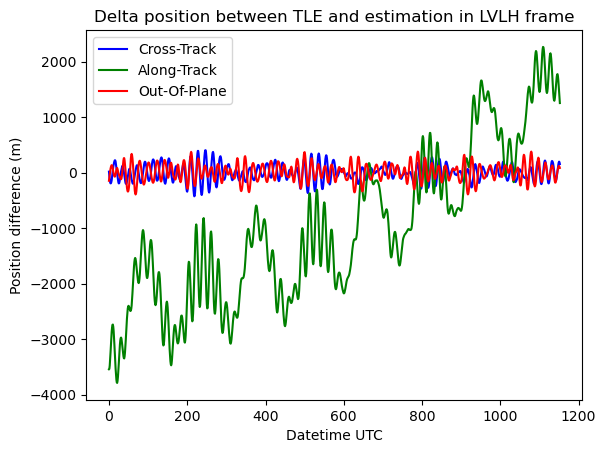

In [67]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plotting the data
ax.plot(deltaPV_tle_lvlh_df.index, deltaPV_tle_lvlh_df['x'], label='Cross-Track', color='blue')
ax.plot(deltaPV_tle_lvlh_df.index, deltaPV_tle_lvlh_df['y'], label='Along-Track', color='green')
ax.plot(deltaPV_tle_lvlh_df.index, deltaPV_tle_lvlh_df['z'], label='Out-Of-Plane', color='red')

# Set the title and labels
ax.set_title('Delta position between TLE and estimation in LVLH frame')
ax.set_xlabel('Datetime UTC')
ax.set_ylabel('Position difference (m)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

## Fitting an "enhanced" TLE
Let's fit a TLE to the estimated propagator. This requires the original TLE. If no TLE is available, then a first guess can be built by:

* Computing the Keplerian orbital elements from the propagator, for example using RV2COE at one instant.
* Writing these elements to the TLE. Although these elements are not mean elements, they will be fitted within a certain range.
* Write the BSTAR coefficient equal to zero. It is a free parameter in the fitting

### Fitting
Fitting the TLE, based on great example by RomaricH on the Orekit forum: https://forum.orekit.org/t/generation-of-tle/265/4

In [68]:
from org.orekit.propagation.conversion import TLEPropagatorBuilder, FiniteDifferencePropagatorConverter
from org.orekit.propagation.analytical.tle import TLEPropagator
threshold = 1.0  # "absolute threshold for optimization algorithm", but no idea about its impact
tle_builder = TLEPropagatorBuilder(orekitTle, PositionAngleType.MEAN, 1.0)
fitter = FiniteDifferencePropagatorConverter(tle_builder, threshold, 1000)
fitter.convert(states_list, False, 'BSTAR')  # Setting BSTAR as free parameter
tle_propagator = TLEPropagator.cast_(fitter.getAdaptedPropagator())
tle_fitted = tle_propagator.getTLE()

InvalidArgsError: (<class 'org.orekit.propagation.conversion.TLEPropagatorBuilder'>, '__init__', (<TLE: 1 42829U 17042E   19338.93232017 +.00000015 +00000-0 +68468-5 0  9993
2 42829 097.5429 224.5636 0013299 211.4408 148.6018 14.91030680130155>, <PositionAngleType: MEAN>, 1.0))

Let's compare both the original and the "enhanced" TLE:

In [36]:
print(orekitTle)
print('')
print(tle_fitted)

1 42829U 17042E   19338.93232017 +.00000015 +00000-0 +68468-5 0  9993
2 42829 097.5429 224.5636 0013299 211.4408 148.6018 14.91030680130155

1 42829U 17042E   19338.93232017  .00000000  00000-0 -50870-4 0  9995
2 42829  97.5425 224.5636 0013154 211.6158 148.4248 14.91029940130155


Let us propagate again to save the PV from this new TLE

In [37]:
# Setting up yet another SGP4 propagator
sgp4Propagator_fitted = SGP4(tle_fitted, nadirPointing, sat_list[sc_name]['mass'])

In [38]:
PV_tle_fitted_eci_df = pd.DataFrame()
deltaPV_tle_fitted_lvlh_df = pd.DataFrame() # SGP4 PV from SLROD origin

date_current = date_start
while date_current.compareTo(date_end) <= 0:    
    datetime_current = absolutedate_to_datetime(date_current)
    
    PV_tle_fitted_eci = sgp4Propagator_fitted.getPVCoordinates(date_current, eci)
    PV_tle_fitted_eci_df = PV_tle_fitted_eci_df.append(orekitPV2dataframe(PV_tle_fitted_eci, datetime_current))
    
    deltaPV_tle_fitted_lvlh = sgp4Propagator_fitted.getPVCoordinates(date_current, lvlh)
    deltaPV_tle_fitted_lvlh_df = deltaPV_tle_fitted_lvlh_df.append(orekitPV2dataframe(deltaPV_tle_fitted_lvlh, datetime_current))
    
    date_current = date_current.shiftedBy(dt)    

### Comparing with estimated propagator

The individual components in LVLH frame are now more centered around zero. The fitting helped. In some cases, the fitted TLE is much better, in some cases not.

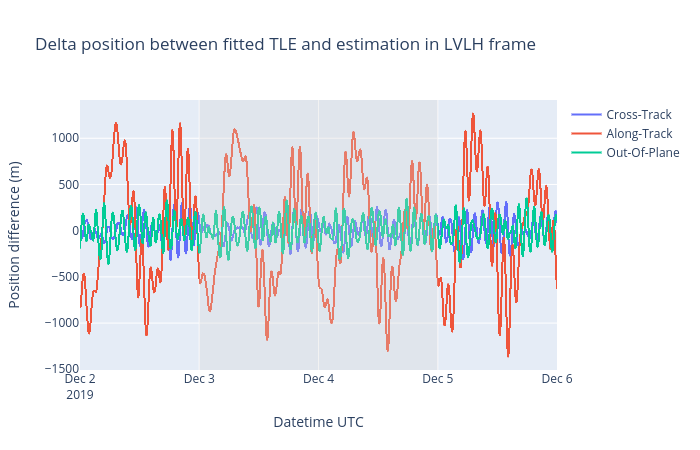

In [39]:
import plotly.graph_objs as go

traceX = go.Scattergl(
    x = deltaPV_tle_fitted_lvlh_df['x'].index,
    y = deltaPV_tle_fitted_lvlh_df['x'],
    mode='lines',
    name='Cross-Track'
)

traceY = go.Scattergl(
    x = deltaPV_tle_fitted_lvlh_df['y'].index,
    y = deltaPV_tle_fitted_lvlh_df['y'],
    mode='lines',
    name='Along-Track'
)

traceZ = go.Scattergl(
    x = deltaPV_tle_fitted_lvlh_df['z'].index,
    y = deltaPV_tle_fitted_lvlh_df['z'],
    mode='lines',
    name='Out-Of-Plane'
)

data = [traceX, traceY, traceZ]

layout = go.Layout(
    title = 'Delta position between fitted TLE and estimation in LVLH frame',
    xaxis = dict(
        title = 'Datetime UTC'
    ),
    yaxis = dict(
        title = 'Position difference (m)'
    ),
    shapes=[od_window_rectangle]
)

fig = dict(data=data, layout=layout)

pio.show(fig)

In [69]:
#Example starlink COV data:

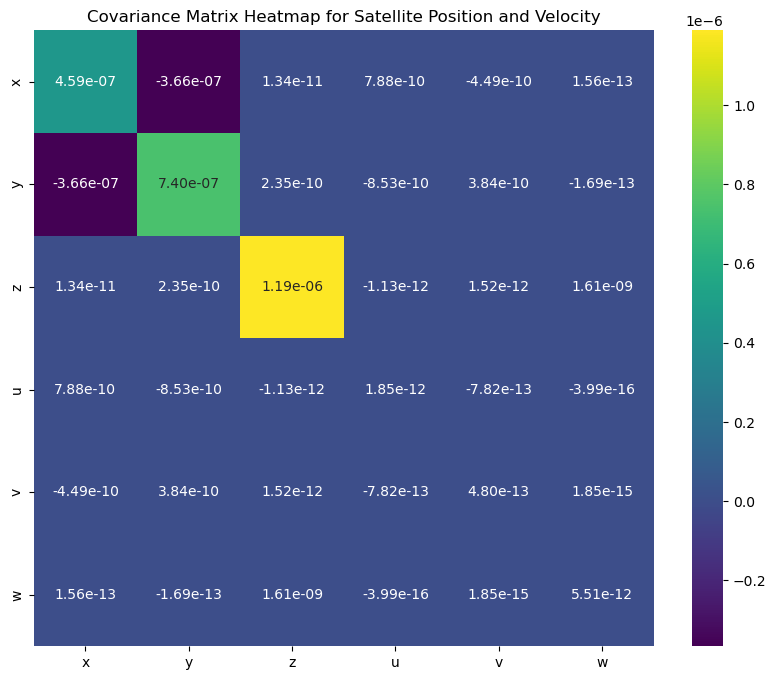

In [71]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Covariance data (lower diagonal of the covariance matrix)
# 2023353064542.000 3163.3779023663 4612.8581212151 -4107.4768053982 -6.7363410087 2.3366847298 -2.5650390934
cov_data = [
    4.5859888162e-07, -3.6646987854e-07, 7.3973575422e-07, 1.3425290468e-11, 2.3545521959e-10, 1.1893972907e-06,
    7.8820183583e-10, -8.5273963678e-10, -1.1268426167e-12, 1.8510977481e-12, -4.4887947676e-10, 3.8449267442e-10,
    1.5151517508e-12, -7.8240396576e-13, 4.7994202102e-13, 1.5627550187e-13, -1.6929403323e-13, 1.6130770620e-09,
    -3.9943729114e-16, 1.8458921288e-15, 5.5050996246e-12
]

# Creating the covariance matrix
cov_matrix = np.zeros((6, 6))

# Filling the lower diagonal of the matrix
row, col = np.tril_indices(6)
cov_matrix[row, col] = cov_data

# Symmetrizing the matrix (since the covariance matrix is symmetric)
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())

# Labels for the axes
labels = ["x", "y", "z", "u", "v", "w"]

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2e", xticklabels=labels, yticklabels=labels, cmap="viridis")
plt.title("Covariance Matrix Heatmap for Starlink Position and Velocity")
plt.show()

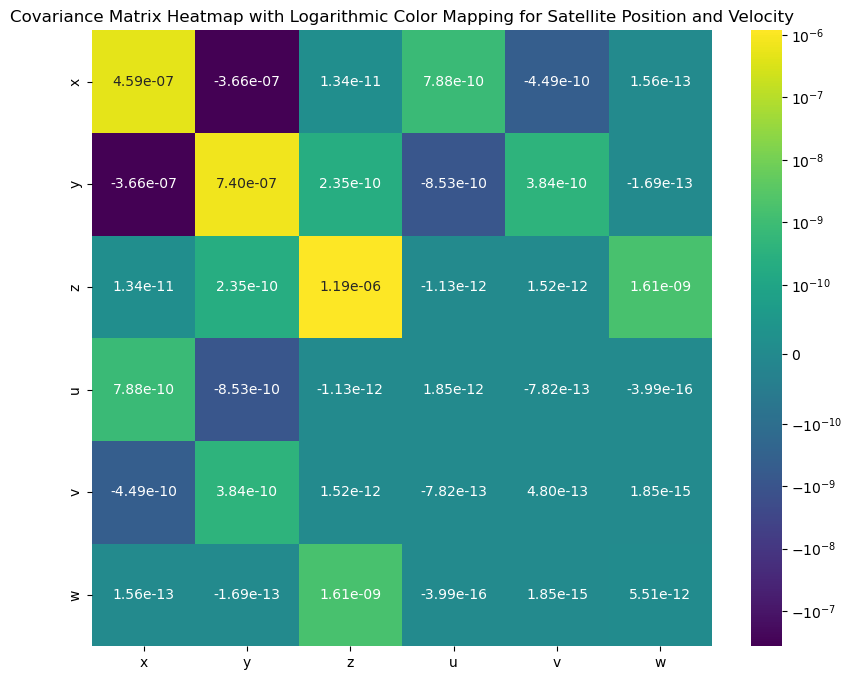

In [74]:
# Adjusting the heatmap to apply a logarithmic transformation to the color mapping
#import SymLogNorm
from matplotlib.colors import SymLogNorm
# Re-creating the covariance matrix
cov_matrix = np.zeros((6, 6))
row, col = np.tril_indices(6)
cov_matrix[row, col] = cov_data
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())

# Labels for the axes
labels = ["x", "y", "z", "u", "v", "w"]

# Plotting the heatmap with a logarithmic transformation to the color mapping
plt.figure(figsize=(10, 8))

# Using a logarithmic transformation for the color mapping
# Adding a small constant to avoid log(0)
from matplotlib.colors import SymLogNorm
log_norm = SymLogNorm(linthresh=1e-10, vmin=cov_matrix.min(), vmax=cov_matrix.max())

# Creating the heatmap
sns.heatmap(cov_matrix, annot=True, fmt=".2e", xticklabels=labels, yticklabels=labels, cmap="viridis", norm=log_norm)
plt.title("Covariance Matrix Heatmap with Logarithmic Color Mapping for Satellite Position and Velocity")
plt.show()